<a href="https://colab.research.google.com/github/dimakis/donut_test/blob/main/Donut_Fine_tuning_ubiai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   import needed pckg

2.   explore & prepare data

3.   Finetune the DonUT model on the data
 * load the fine-tuned model and see its results on an **image example**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import torch

!git clone https://github.com/clovaai/donut.git
!cd donut && pip install .
from donut import DonutModel

import json
import shutil

Cloning into 'donut'...
remote: Enumerating objects: 228, done.
remote: Total 228 (delta 0), reused 0 (delta 0), pack-reused 228
Receiving objects: 100% (228/228), 62.75 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/donut
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 5.3 MB 30.7 MB/s 
     |████████████████████████████████| 548 kB 62.3 MB/s 
     |████████████████████████████████| 441 kB 67.0 MB/s 
     |████████████████████████████████| 708 kB 69.9 MB/s 
     |████████

# explore &&  prepare data

In [ ]:
ubiai_data_folder = "/content/drive/MyDrive/Invoice dataset/UBIAI_dataset"
ubiai_ocr_results = "/content/drive/MyDrive/Invoice dataset/UBIAI_dataset/ocr.json"

processed_dataset_folder = "/content/drive/MyDrive/Colab Notebooks/UBIAI_dataset/processed_dataset"

In [ ]:
with open(ubiai_ocr_results) as f:
  data = json.load(f)

In [ ]:
ls

donut/  drive/  sample_data/


In [ ]:
all_labels = list()
for j in data:
  all_labels += list(j['annotation'][cc]['label'] for cc in range(len(j['annotation'])))

all_labels = set(all_labels)
all_labels

In [ ]:
print('Distribution of labels in the annotations of the dataset, having %d images:\n'%len(data))

for label in all_labels:
  if 'ID' not in label:
    n = 0
    for obs in data:
      for ann in obs['annotation']:
        if ann['label'] == label:
          n += 1
    print('%s : %d\n'%(label,n))

In [ ]:
images_metadata = list()
images_path = list()

for obs in data:

  ground_truth = dict()
  for ann in obs['annotation']:
    if ann['label'].strip() in ['SELLER', 'DATE', 'TTC', 'INVOICE_NUMBERS', 'TVA']:
      ground_truth[ann['label'].strip()] = ann['text'].strip()

  try:
    ground_truth = {key : ground_truth[key] for key in ['SELLER', 'DATE', 'TTC', 'INVOICE_NUMBERS', 'TVA']}
  except:
    continue

  images_metadata.append({"gt_parse": ground_truth})
  images_path.append(obs['images'][0]['name'].replace(':',''))

dataset_len = len(images_metadata)
print("train data : %d \n test data : %d \n validation data : %d"%(round(dataset_len*0.8),round(dataset_len*0.1),round(dataset_len*0.1)))

In [ ]:
for i, gt_parse in enumerate(images_metadata):

  if images_path[i] == "050320sasdoodahfev20_2021-09-24_0722.txt_image_0.jpg":
    print(i, gt_parse)
  # train
  if i < round(dataset_len*0.8) :
    with open(processed_dataset_folder+"/train/metadata.jsonl", 'a') as f:
      line = {"file_name": images_path[i], "ground_truth": json.dumps(gt_parse, ensure_ascii=False)}
      f.write(json.dumps(line, ensure_ascii=False) + "\n")
      shutil.copyfile(ubiai_data_folder + '/' + images_path[i], processed_dataset_folder + "/train/" + images_path[i])
      if images_path[i] == "050320sasdoodahfev20_2021-09-24_0722.txt_image_0.jpg":
        print('train')

  # test
  if round(dataset_len*0.8) <= i < round(dataset_len*0.8) + round(dataset_len*0.1):
    with open(processed_dataset_folder+"/test/metadata.jsonl", 'a') as f:
        line = {"file_name": images_path[i], "ground_truth": json.dumps(gt_parse, ensure_ascii=False)}
        f.write(json.dumps(line, ensure_ascii=False) + "\n")
        shutil.copyfile(ubiai_data_folder + '/' + images_path[i], processed_dataset_folder + "/test/" + images_path[i])
        if images_path[i] == "050320sasdoodahfev20_2021-09-24_0722.txt_image_0.jpg":
          print('test')

  # validation
  if round(dataset_len*0.8) + round(dataset_len*0.1) <= i < dataset_len:
    with open(processed_dataset_folder+"/validation/metadata.jsonl", 'a') as f:
        line = {"file_name": images_path[i], "ground_truth": json.dumps(gt_parse, ensure_ascii=False)}
        f.write(json.dumps(line, ensure_ascii=False) + "\n")
        shutil.copyfile(ubiai_data_folder + '/' + images_path[i], processed_dataset_folder + "/validation/" + images_path[i])

# Finetune the DonUT model on the data

**⚠️ Go to "/content/donut/config" folder, add a new file called "train_ubiai.yaml" and copy the following config rows in it:**
```
resume_from_checkpoint_path: null # only used for resume_from_checkpoint option in PL
result_path: "/content/drive/MyDrive/Invoice dataset/UBIAI_dataset/processed_dataset/result"
pretrained_model_name_or_path: "naver-clova-ix/donut-base" # loading a pre-trained model (from moldehub or path)
dataset_name_or_paths: ["/content/drive/MyDrive/Invoice dataset/UBIAI_dataset/processed_dataset"] # loading datasets (from moldehub or path)
sort_json_key: False # cord dataset is preprocessed, and publicly available at https://huggingface.co/datasets/naver-clova-ix/cord-v2
train_batch_sizes: [1]
val_batch_sizes: [1]
input_size: [1280, 960] # when the input resolution differs from the pre-training setting, some weights will be newly initialized (but the model training would be okay)
max_length: 768
align_long_axis: False
num_nodes: 1
seed: 2022
lr: 3e-5
warmup_steps: 300 # 800/8*30/10, 10%
num_training_samples_per_epoch: 800
max_epochs: 50
max_steps: -1
num_workers: 8
val_check_interval: 1.0
check_val_every_n_epoch: 3
gradient_clip_val: 1.0
verbose: True
```



In [ ]:
# train the model
!cd donut && python train.py --config config/train_ubiai.yaml

### load the fine-tuned model and see its results on an image example

In [ ]:
my_model = DonutModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Downloading:   0%|          | 0.00/404 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/859M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536 [00:00<?, ?B/s]

In [ ]:
my_model = DonutModel.from_pretrained("/content/drive/MyDrive/Invoice dataset/UBIAI_dataset/processed_dataset/result/train_ubiai/20221019_002304").half().to(torch.device("cuda")).eval()

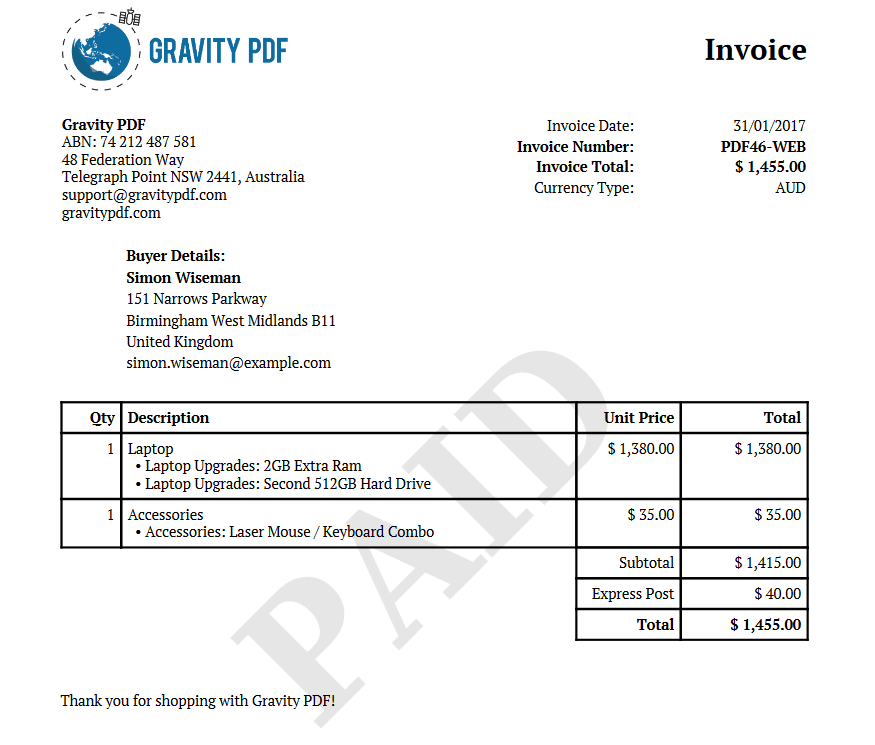


Fine-tuned DonUT annotation results:



{'predictions': [{'DATE': '31/01/2017',
   'TTC': '$1,455.00',
   'INVOICE_NUMBERS': 'INVOICE',
   'TVA': '$35.00'}]}

In [ ]:
image = Image.open("Invoice Example.png").convert("RGB")

img = image.resize((round(image.size[0]/3), round(image.size[1]/3)))
display(image)

donut_result = my_model.inference(image=image, prompt="<s_ubiai-donut>")

print("\nFine-tuned DonUT annotation results:\n")
donut_result

In [ ]:
# Compare annotation results (printed just above) of the DonUT model that we have fine tuned on our data, with the ground truth
print("Ground truth:\n")
images_metadata[images_path.index('1555322739590_2021-10-26_195917.5.txt_image_0.jpg')]['gt_parse']

Ground truth:



{'SELLER': 'La Brulerie de Belleville SARL',
 'DATE': '11 Jan 2019',
 'TTC': '105.50',
 'INVOICE_NUMBERS': 'F-8255',
 'TVA': '5.50'}

```
* predicted_DATE == true_DATE

* predicted_TTC == true_TTC

* predicted_INVOICE_NUMBERS == true_INVOICE_NUMBER

* predicted_TVA == true_TVA

* no predicted_SELLER

```



TEST

In [ ]:
import glob
with open('/content/drive/MyDrive/Invoice dataset/UBIAI_dataset/processed_dataset/test/metadata.jsonl') as f:
  result = [json.loads(jline) for jline in f.read().splitlines()]
test_images = glob.glob(processed_dataset_folder+'/test/*.jpg')

acc_dict = {'SELLER' : 0, 'DATE' : 0, 'TTC' : 0, 'INVOICE_NUMBERS' : 0, 'TVA' : 0}

for path in test_images:
  image = Image.open(path).convert("RGB")

  donut_result = my_model.inference(image=image, prompt="<s_ubiai-donut>")
  returned_labels = donut_result['predictions'][0].keys()

  for i in result:
    if i['file_name'] == path[path.index('/test/')+6:]:
      truth = json.loads(i['ground_truth'])['gt_parse']
      break

  for l in [x for x in returned_labels if x in ['SELLER', 'DATE', 'TTC', 'INVOICE_NUMBERS', 'TVA']]:
    if donut_result['predictions'][0][l] == truth[l]:
      acc_dict[l] +=1

In [ ]:
print("Model accuracy test for each field:\n")
for i in acc_dict.keys():
  print(i, ": ", round((acc_dict[i]/19)*100),"% (" , acc_dict[i],"/19)\n", sep='')

Model accuracy test for each field:

SELLER: 0% (0/19)

DATE: 47% (9/19)

TTC: 74% (14/19)

INVOICE_NUMBERS: 53% (10/19)

TVA: 63% (12/19)

